## Predicting polymer glass transition temperature using neural networks

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from rdkit import Chem

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


## 2. Read file

In [2]:
df = pd.read_csv('molecules.csv', encoding = 'unicode_escape')
print(df.shape)
df.head(10)

(392, 3)


,Tg,Molecular Structure,Nomenclature Name
0,279.0,C=CC(=O)OCc1ccccc1,Poly(benzyl acrylate)
1,383.0,C=CC(=O)Oc2ccc(c1ccccc1)cc2,Poly(4-biphenyl acrylate)
2,219.0,CCCCOC(=O)C=C,Poly(butyl acrylate)
3,250.0,CC(OC(=O)C=C)CC,Poly(sec-butyl acrylate)
4,345.0,C=CC(=O)Oc1ccccc1C(C)(C)C,Poly(2-tertbutylphenyl acrylate)
5,344.0,C=CC(=O)Oc1ccc(C(C)(C)C)cc1,Poly(4-tertbutylphenyl acrylate)
6,NaN,NaN,NaN
7,NaN,NaN,NaN
8,317.0,C=CC(=O)Oc1ccc(C#N)cc1,Poly(4-cyanobenzyl acrylate)
9,324.0,C=CC(=O)OCC(C)C#N,Poly(2-cyanoisobutyl acrylate)


## 3. Clean Data - Check for missing values

In [3]:
df.apply(lambda x: x.isna().value_counts())

,Tg,Molecular Structure,Nomenclature Name
False,352,352,352
True,40,40,40


In [4]:
df.dropna(how='all', inplace=True)
df.shape

(352, 3)

## 4.0 Molecular structure to Image encoding

### 4.1 Create a LIST containing the 'SMILES CODE' of the polymers from the dataframe

In [5]:
smiles_list = [i for i in df['Molecular Structure']]
print('Polymer count:', len(smiles_list))
print(smiles_list[:3])

Polymer count: 352
['C=CC(=O)OCc1ccccc1', 'C=CC(=O)Oc2ccc(c1ccccc1)cc2', 'CCCCOC(=O)C=C']


### 4.2 Get the length of the largest chain

In [6]:
smiles_length = [len(i) for i in smiles_list]
smiles_length.sort(reverse=True)
smiles_length[0]

65

### 4.3  Create a list containing unique characters that are present in the SMILES string of the polymer 

In [7]:
smiles_char = ['c', 'n', 'o', 'r', 'l','C', 'B','N', 'F', 'Cl', 'Br','O','S','1','2', '3',
               '=', '#', '/', ')', '(', '.', ' ', '\xa0']
print('smiles_char_len:', len(smiles_char))

smiles_char_len: 24


### 4.4. Create a char:index dictionary

In [8]:
smiles2index = dict((c,i) for i,c in enumerate(smiles_char))
print(smiles2index)

{'c': 0, 'n': 1, 'o': 2, 'r': 3, 'l': 4, 'C': 5, 'B': 6, 'N': 7, 'F': 8, 'Cl': 9, 'Br': 10, 'O': 11, 'S': 12, '1': 13, '2': 14, '3': 15, '=': 16, '#': 17, '/': 18, ')': 19, '(': 20, '.': 21, ' ': 22, '\xa0': 23}


### 4.5 Smiles Encoder

In [9]:
polymer_count = 352  # from the dataset
smiles_max_len = 65 # length of the largest chain
smiles_char_len = 24 # length of the smiles character list

In [10]:
X = np.zeros((polymer_count, smiles_max_len, smiles_char_len))

for index,smile in enumerate(smiles_list):
    for idx,char in enumerate(smile):
        X[index][idx, smiles2index[char]]=1
        
print(X[0]) 
print(len(X))
print(X.shape)        

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
352
(352, 65, 24)


### 4.6 Plot the Encoded Image

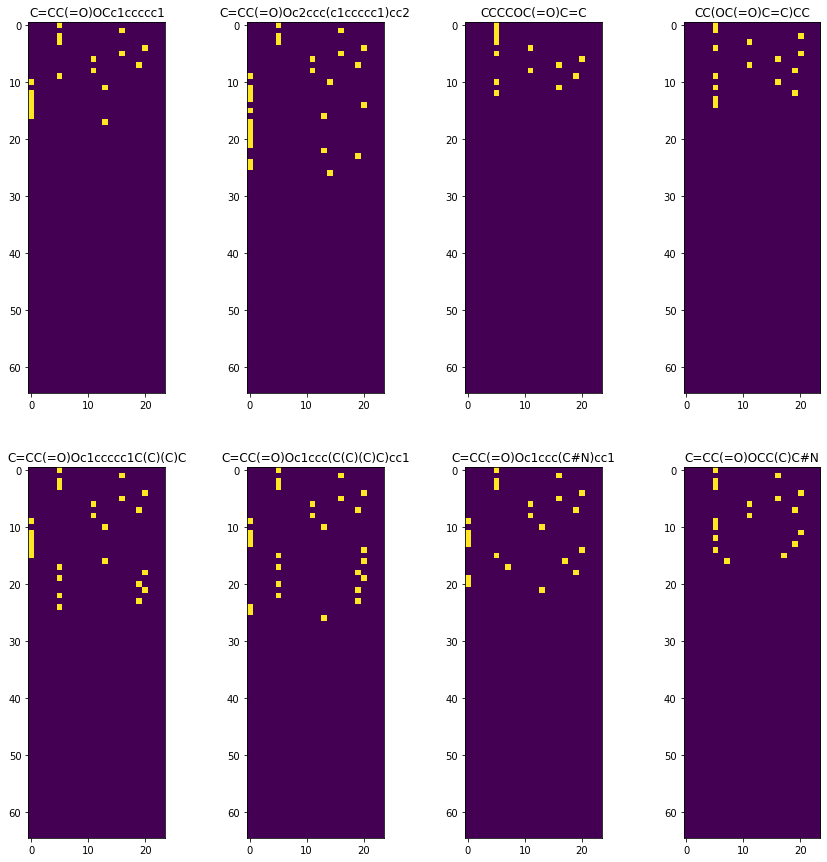

In [11]:
plt.figure(figsize=(15,15))

X_ = X[:8]
for i in range(len(X_)):
    plt.subplot(2,4,i+1)
    plt.title(smiles_list[i])
    plt.imshow(X_[i])
    

## 5.0 Buid Model - CNN

In [12]:
X = X.reshape(352, 65, 24, 1)
y = df['Tg']
print(X.shape)
print(y.shape)

(352, 65, 24, 1)
(352,)


In [13]:
batch_size = 64
epochs = 200

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=123)


In [15]:
y_test[:10]

256    267.0
261    297.0
287    178.0
13     258.0
26     249.0
368    234.0
265    272.0
231    438.0
133    217.0
180    349.0
Name: Tg, dtype: float64

In [16]:
from keras.optimizers import Adam
from keras.losses import mean_absolute_error
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same',
                   kernel_regularizer=l2(0.01), input_shape=(65,24,1)))
model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same',
              kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D((2,2)))


model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same',
                kernel_regularizer=l2(0.01))) 
model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same',
               kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())  

model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.01)))

model.add(Dense(1))

model.summary()          

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 65, 24, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 65, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 12, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 6, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6144)             

In [17]:
optimizer=Adam(lr=0.01)
#optimizer=SGD(lr=0.01)

model.compile(optimizer=optimizer, loss='mean_absolute_error')

model_cnn=model.fit(X_train, y_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_split=0.1)

Train on 269 samples, validate on 30 samples
Epoch 1/200
269/269 [==============================] - 2s 6ms/step - loss: 508.7928 - val_loss: 281.8488
Epoch 2/200
269/269 [==============================] - 1s 5ms/step - loss: 299.5107 - val_loss: 283.4161
Epoch 3/200
269/269 [==============================] - 1s 5ms/step - loss: 285.2917 - val_loss: 217.2736
Epoch 4/200
269/269 [==============================] - 1s 5ms/step - loss: 159.3161 - val_loss: 101.8142
Epoch 5/200
269/269 [==============================] - 1s 5ms/step - loss: 95.6859 - val_loss: 85.1157
Epoch 6/200
269/269 [==============================] - 1s 5ms/step - loss: 77.9062 - val_loss: 68.1228
Epoch 7/200
269/269 [==============================] - 1s 5ms/step - loss: 71.4315 - val_loss: 68.1243
Epoch 8/200
269/269 [==============================] - 1s 5ms/step - loss: 68.0489 - val_loss: 69.9266
Epoch 9/200
269/269 [==============================] - 1s 5ms/step - loss: 63.7316 - val_loss: 58.4694
Epoch 10/200
269/269

269/269 [==============================] - 1s 5ms/step - loss: 14.4313 - val_loss: 18.4560
Epoch 158/200
269/269 [==============================] - 1s 5ms/step - loss: 17.2592 - val_loss: 27.2757
Epoch 159/200
269/269 [==============================] - 1s 5ms/step - loss: 20.1346 - val_loss: 28.6036
Epoch 160/200
269/269 [==============================] - 1s 5ms/step - loss: 18.0493 - val_loss: 27.5709
Epoch 161/200
269/269 [==============================] - 1s 5ms/step - loss: 16.8388 - val_loss: 19.4635
Epoch 162/200
269/269 [==============================] - 1s 5ms/step - loss: 11.4621 - val_loss: 18.9152
Epoch 163/200
269/269 [==============================] - 1s 5ms/step - loss: 11.6584 - val_loss: 22.6595
Epoch 164/200
269/269 [==============================] - 1s 5ms/step - loss: 17.9740 - val_loss: 23.7289
Epoch 165/200
269/269 [==============================] - 1s 5ms/step - loss: 14.8115 - val_loss: 20.4980
Epoch 166/200
269/269 [==============================] - 1s 5ms/step 

## 6.0 Plot Learning Curve

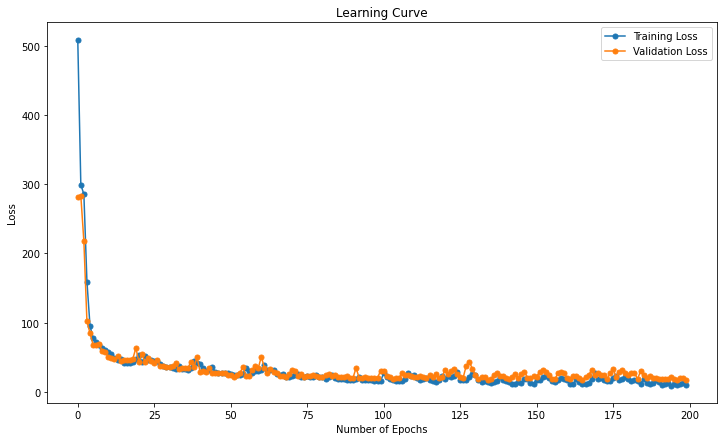

In [18]:
plt.figure(figsize=(12,7))
plt.title('Learning Curve')
plt.plot(model_cnn.history['loss'], marker='.', markersize=10,label='Training Loss')
plt.plot(model_cnn.history['val_loss'], marker='.',markersize=10, label='Validation Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 7.0 Evaluate Model

In [19]:
score=model.evaluate(X_test, y_test)
print(score)

53/53 [==============================] - 0s 2ms/step
27.867318207362914


## 8.0 Predictions

In [20]:
y_train_pred = model.predict(X_train)
y_test_pred =  model.predict(X_test)

In [21]:
MAE_train = abs(y_train_pred.reshape(y_train.shape) - y_train).sum()/y_train.shape
MAE_test = abs(y_test_pred.reshape(y_test.shape) - y_test).sum()/y_test.shape
print('Train Data Mean Absolute Error:', MAE_train)
print('Test Data Mean Absolute Error:', MAE_test)

Train Data Mean Absolute Error: [6.70934018]
Test Data Mean Absolute Error: [23.80471456]


## 9.0 Comparison plot predicted Vs true Tg for Train and Test data

[Text(0.5, 0, 'True Tg'), Text(0, 0.5, 'Predicted Tg')]

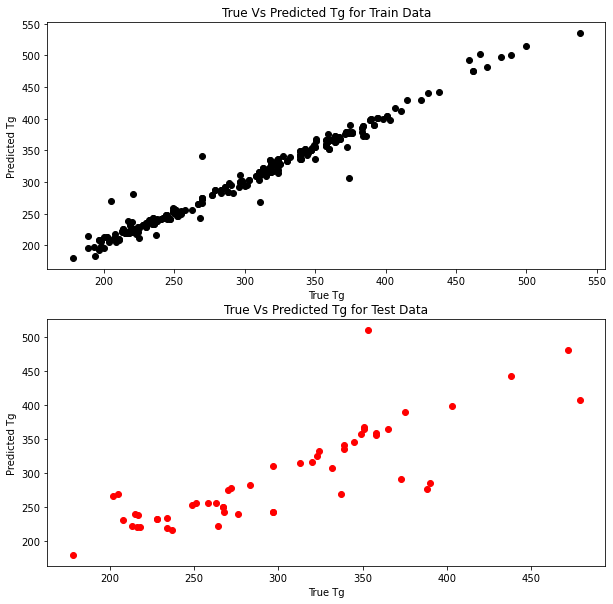

In [22]:
fig,ax = plt.subplots(2,1, figsize=(10,10))

y_trainPred=y_train_pred.reshape(y_train.shape)
y_testPred=y_test_pred.reshape(y_test.shape)

ax[0].scatter(y_train, y_trainPred, marker='o', color='k')
ax[0].set_title('True Vs Predicted Tg for Train Data')
ax[0].set(xlabel='True Tg', ylabel='Predicted Tg')

ax[1].scatter(y_test, y_testPred, marker='o', color='r')
ax[1].set_title('True Vs Predicted Tg for Test Data')
ax[1].set(xlabel='True Tg', ylabel='Predicted Tg')

## 10.0 Evaluation Metric- % Relative Error

In [23]:
train_error = (abs((y_trainPred-y_train)/y_train).sum())*100*1/y_train.shape
test_error = (abs((y_testPred-y_test)/y_test).sum())*100*1/y_test.shape
print('% Relative Train Error:', train_error.round(2))
print('% Relative Test Error:', test_error.round(2))

% Relative Train Error: [2.34]
% Relative Test Error: [7.86]


## 11.0 Comparison of True and Predicted Tg on Test Data

In [24]:
df1 = pd.DataFrame(y_test)
df1 = df1.rename(columns={'Tg':'True Tg'})
df1.head(2)

,True Tg
256,267.0
261,297.0


In [25]:
df2 = pd.DataFrame(y_testPred, index = df1.index, columns=['Predicted Tg'])
df2['Predicted Tg']=df2['Predicted Tg'].apply(lambda x: round(x,2))
df2.head(2)

,Predicted Tg
256,249.85
261,311.09


In [26]:
df3 = df1.join(df2)
df3.head(2)

,True Tg,Predicted Tg
256,267.0,249.85
261,297.0,311.09


In [27]:
df4 = df[df.index.isin(df3.index)]
df4.head(2)

,Tg,Molecular Structure,Nomenclature Name
11,358.0,C=CC(=O)OCCCCCCC#N,Poly(2-cyanohexyl acrylate)
13,258.0,C=CC(=O)OCC(C)C(C)CC,"Poly(1,3-dimethylbutyl acrylate)"


In [29]:
final = df4.join(df3)
final.drop(columns=['Tg'], inplace=True)
final.head()

,Molecular Structure,Nomenclature Name,True Tg,Predicted Tg
11,C=CC(=O)OCCCCCCC#N,Poly(2-cyanohexyl acrylate),358.0,356.18
13,C=CC(=O)OCC(C)C(C)CC,"Poly(1,3-dimethylbutyl acrylate)",258.0,255.85
17,C=CC(=O)OCCCOCC,Poly(3-ethoxypropyl acrylate),218.0,220.62
22,C=CC(=O)OC(F)(C(F)(F)F)C(F)(F)F,Poly(heptafluoro-2-propyl acrylate),283.0,282.78
26,C=CC(=O)OCC(C)C,Poly(isobutyl acrylate),249.0,252.61
